根据调研，发现有以下几种基于AST来检测代码相似度的方法：
- Min-Hashing based Jaccard Similarity：应用Jaccard Similarity来检测，输入的数据为treesitter解析树的前序序列

### Min-Hashing based Jaccard Similarity

In [8]:
from datasketch import MinHash
from tree_sitter import Language, Parser
import ast
def traverse_tree(node,token_list):
    if type(node) == list:   
        for n in node:
            token_list.append(n.type)
            traverse_tree(n,token_list)
    else:
        if node.children == []:
            return
        token_list.append(node.type)
        traverse_tree(node.children,token_list)
#解析代码获取parsetree
def getast_tree(language,text):
    LANGUAGE=Language('build/my-languages.so', language)
    parser=Parser()
    parser.set_language(LANGUAGE)
    tree=parser.parse(bytes(text,"utf8"))
    cusor=tree.walk()
    token_list=[]
    traverse_tree(tree.root_node,token_list)
    return token_list
def MinHash_AST(lang1,text1,lang2,text2):
    data1=getast_tree(lang1,text1)
    data2=getast_tree(lang2,text2)
    m1, m2 = MinHash(), MinHash()
    for d in data1:
        m1.update(d.encode('utf8'))
    for d in data2:
        m2.update(d.encode('utf8'))
    return m1.jaccard(m2)
def MinHash_CODE(text1,text2):
    data1=text1.split()
    data2=text2.split()
    m1, m2 = MinHash(), MinHash()
    for d in data1:
        m1.update(d.encode('utf8'))
    for d in data2:
        m2.update(d.encode('utf8'))
    return m1.jaccard(m2)

In [17]:
lang1='cpp'
text1='''#include<stdio.h>
#include<math.h>
#include<string>
#include<map>
using namespace std;
#include<algorithm>
#include<stdlib.h>
string sort_numbers(string numbers){

    map<string,int> tonum={{"zero",0},{"one",1},{"two",2},{"three",3},{"four",4},{"five",5},{"six",6},{"seven",7},{"eight",8},{"nine",9}};
    map<int,string> numto={{0,"zero"},{1,"one"},{2,"two"},{3,"three"},{4,"four"},{5,"five"},{6,"six"},{7,"seven"},{8,"eight"},{9,"nine"}};
    int count[10];
    for (int i=0;i<10;i++)
        count[i]=0;
    string out="",current="";
    if (numbers.length()>0) numbers=numbers+' ';
    for (int i=0;i<numbers.length();i++)
        if (numbers[i]==' ')
        {
            count[tonum[current]]+=1;
            current="";
        }
        else current+=numbers[i];
    for (int i=0;i<10;i++)
        for (int j=0;j<count[i];j++)
            out=out+numto[i]+' ';
    if (out.length()>0) out.pop_back();
    return out;
}
'''
lang2='java'
text2='''
import java.util.*;
import java.lang.*;

class Solution {
    public String sortNumbers(String numbers) {
        int[] tonum = {
            0, 1, 2, 3, 4, 5, 6, 7, 8, 9 
        };
        String[] numto = {
            "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine" 
        };
        int count[] = new int[10];
        String out = "";
        String current = "";
        if (numbers.length() > 0) numbers = numbers +'';
        for(int i = 0; i < numbers.length(); i ++) {
            if (numbers.charAt(i) =='') count[tonum[current.charAt(0) - '0']] ++;
            current += numbers.charAt(i);
        }
        for(int i = 0; i < 10; i ++) {
            for(int j = 0; j < count[i]; j ++) {
                out = out + numto[i] +'';
            }
        }
        if (out.length() > 0) out = out.substring(0, out.length() - 1);
        return out;
    }
}
'''
data1=getast_tree(lang1,text1)
data2=getast_tree(lang2,text2)
print(data2)

['program', 'import_declaration', 'import_declaration', 'import', 'scoped_identifier', 'scoped_identifier', 'identifier', '.', 'identifier', '.', 'asterisk', 'asterisk', '*', ';', 'import_declaration', 'import_declaration', 'import', 'scoped_identifier', 'scoped_identifier', 'identifier', '.', 'identifier', '.', 'asterisk', 'asterisk', '*', ';', 'class_declaration', 'class_declaration', 'class', 'identifier', 'class_body', 'class_body', '{', 'method_declaration', 'method_declaration', 'modifiers', 'modifiers', 'public', 'type_identifier', 'identifier', 'formal_parameters', 'formal_parameters', '(', 'formal_parameter', 'formal_parameter', 'type_identifier', 'identifier', ')', 'block', 'block', '{', 'local_variable_declaration', 'local_variable_declaration', 'array_type', 'array_type', 'integral_type', 'integral_type', 'int', 'dimensions', 'dimensions', '[', ']', 'variable_declarator', 'variable_declarator', 'identifier', '=', 'array_initializer', 'array_initializer', '{', 'decimal_integ

In [10]:

with open('./test/similarity/similarity.txt','r') as f:
    mytext=f.readlines()
text=[]
language=[]
for i in mytext:
    tempdict=ast.literal_eval(i)
    language.append(tempdict['language'])
    text.append(tempdict['text'])

dict_minhash_ast={}
dict_minhash_token={}

for i in range(2,len(text)+1):
        dict_minhash_ast[(1,i)]=MinHash_AST(language[0],text[0],language[i-1],text[i-1])
        dict_minhash_token[(1,i)]=MinHash_CODE(text[0],text[i-1])
print(dict_minhash_ast)
print(dict_minhash_token)
'''s1 = set(data1)
        s2 = set(data2)
        actual_jaccard = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))
        print(i,j, actual_jaccard)'''

{(1, 2): 0.984375, (1, 3): 1.0, (1, 4): 0.8671875, (1, 5): 1.0, (1, 6): 0.9609375, (1, 7): 0.890625, (1, 8): 0.8984375, (1, 9): 0.546875, (1, 10): 0.3203125}
{(1, 2): 0.421875, (1, 3): 0.921875, (1, 4): 0.8125, (1, 5): 0.4453125, (1, 6): 0.8671875, (1, 7): 0.4921875, (1, 8): 0.28125, (1, 9): 0.1171875, (1, 10): 0.1640625}


's1 = set(data1)\n        s2 = set(data2)\n        actual_jaccard = float(len(s1.intersection(s2)))/float(len(s1.union(s2)))\n        print(i,j, actual_jaccard)'

### SimHash

In [11]:
from simhash import Simhash
def SimHash_AST(lang1,text1,lang2,text2):
    # 将代码字符串转化为 Simhash 对象
    data1=getast_tree(lang1,text1)
    data2=getast_tree(lang2,text2)
    data1=" ".join(data1)
    data2=" ".join(data2)
    simhash3 = Simhash(data1)
    simhash4 = Simhash(data2)
    # 计算两个 Simhash 对象之间的汉明距离
    distance1 = simhash3.distance(simhash4)
    return 1 - distance1 / 64
def SimHash_CODE(text1,text2):
    simhash1 = Simhash(text1)
    simhash2 = Simhash(text2)
    distance = simhash1.distance(simhash2)
    return 1 - distance / 64

In [12]:

from simhash import Simhash
dict_simhash_code={}
dict_simhash_ast={}
'''
for i in range(1,len(text)+1):
    for j in range(i+1,len(text)+1):
        # 将代码字符串转化为 Simhash 对象
        simhash1 = Simhash(text[i-1])
        simhash2 = Simhash(text[j-1])
        # 计算两个 Simhash 对象之间的汉明距离
        distance = simhash1.distance(simhash2)
        # 输出代码相似度
        similarity = 1 - distance / 64
        dict_simhash[(i,j)]=similarity'''

for j in range(2,len(text)+1):
    dict_simhash_code[(1,j)]=SimHash_CODE(text[0],text[j-1])
    dict_simhash_ast[(1,j)]=SimHash_AST(language[0],text[0],language[i-1],text[j-1])
print(dict_simhash_ast)

{(1, 2): 0.671875, (1, 3): 0.703125, (1, 4): 0.671875, (1, 5): 0.703125, (1, 6): 0.671875, (1, 7): 0.75, (1, 8): 0.6875, (1, 9): 0.671875, (1, 10): 0.765625}


### 基于编辑距离比较AST相似度

In [13]:
from tree_sitter import Language, Parser
def ast_similarity(ast1, ast2):
    str1 = ''.join(ast1)
    str2 = ''.join(ast2)
    len1, len2 = len(str1), len(str2)
    if len1 == 0 or len2 == 0:
        return 0.0
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]
    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
    max_len = max(len1, len2)
    similarity = 1 - dp[len1][len2] / max_len
    return similarity
dict_ast_distance={}
'''for i in range(1,len(text)+1):
    for j in range(i+1,len(text)+1):
        data1=getast_tree('c',text[i-1])
        data2=getast_tree('c',text[j-1])
        dict_ast_distance[(i,j)]=ast_similarity(data1,data2)'''

    
for j in range(2,len(text)+1):
    data1=getast_tree(language[0],text[0])
    data2=getast_tree(language[j-1],text[j-1])
    dict_ast_distance[(1,j)]=ast_similarity(data1,data2)
print(dict_ast_distance)

{(1, 2): 0.8190854870775348, (1, 3): 1.0, (1, 4): 0.9355916030534351, (1, 5): 1.0, (1, 6): 0.8378640776699029, (1, 7): 0.5563973063973064, (1, 8): 0.8312085670576237, (1, 9): 0.39367669556348805, (1, 10): 0.3640999490056094}


## Methods效果可视化

- 1.c //用冒泡排序实现
- 2.c //用选择排序实现
- 3.c //完全拷贝1.c
- 4.c//在1.c基础上，添加头文件、空行和注释
- 5.c//在1.c的基础上更改变量名、函数名
- 6.c//在源码1.c的基础上，更改函数语句的次序
- 7.c//在1.c基础上，更改数据类型，循环语句等价替换，增加函数个数
- 8.c//把一个数组相邻两位交换，即结构非常相似，但功能发生了巨大变化
- 9.c//功能和结构都相差较大的函数
- 10.py//python实现冒泡排序

['(1, 2)', '(1, 3)', '(1, 4)', '(1, 5)', '(1, 6)', '(1, 7)', '(1, 8)', '(1, 9)', '(1, 10)']


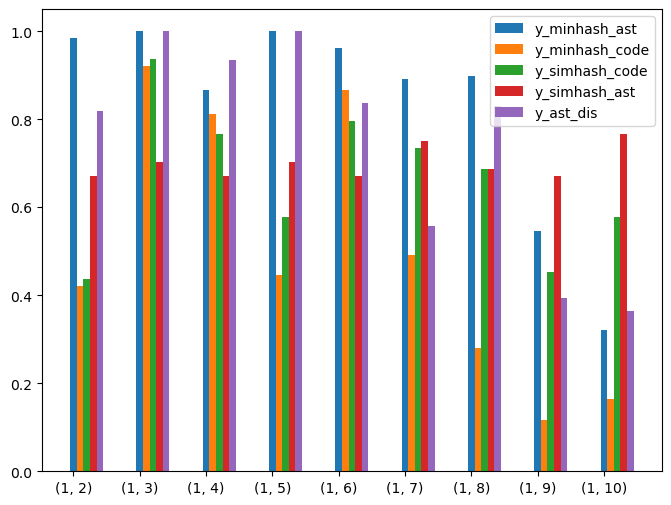

<Figure size 800x600 with 0 Axes>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# 设置图形大小
plt.figure(figsize=(8, 6))
# 准备数据
x_data = [str(i) for i in dict_simhash_code.keys()]
y_minhash_ast=[i for i in dict_minhash_ast.values()]
y_minhash_code=[i for i in dict_minhash_token.values()]
y_simhash=[i for i in dict_simhash_code.values()]
y_ast_dis=[i for i in dict_ast_distance.values()]
y_simhash_ast=[i for i in dict_simhash_ast.values()]
# 有四种类型的数据，n设置为4
total_width, n = 0.5, 5
# 每种类型的柱状图宽度
width = total_width / n

print(x_data)
# 画柱状图
plt.bar(x_data, y_minhash_ast, width=width, label="y_minhash_ast")  
plt.bar([i + width for i in range(len(x_data))],y_minhash_code, width=width, label="y_minhash_code")   
plt.bar([i + 2*width for i in range(len(x_data))], y_simhash, width=width, label="y_simhash_code")
plt.bar([i + 3*width for i in range(len(x_data))], y_simhash_ast, width=width, label="y_simhash_ast")   
plt.bar([i + 4*width for i in range(len(x_data))], y_ast_dis, width=width, label="y_ast_dis")
# 显示图例
plt.legend()
plt.figure(figsize=(8, 6))
# 显示柱状图
plt.show()



 ### 计算相似度

In [15]:
import os
import json
dict_lang={'cpp':'cpp','python':'python','java':'java','js':'javascript','go':'go'}
dict_promptsplit={'cpp': 'C++:', 'go': 'Go:', 'java': 'Java:', 'javascript': 'JavaScript:', 'python': 'Python:'}
def process():
    files="./data/code_translation/code"
    for root,dirs,file in os.walk(files):
        for myfile in file:
            truelist=[]
            similaritylist=[]
            string=myfile.split('-to-')
            lang1=dict_lang[string[0].split('-')[-1]]
            lang2=dict_lang[string[1].split('-')[0]]
            print(lang1,lang2)
            path=os.path.join(root, myfile) 
            with open(path,'r')as f:
                for line in f:
                    obj=json.loads(line)
                    string1=obj['prompt']
                    string1=string1.split(dict_promptsplit[lang1])[1]
                    code1=string1.split(dict_promptsplit[lang2])[0]	
                    code2=string1.split(dict_promptsplit[lang2])[1]+obj['generation']	
                    #print(lang1,code1,'\n\n',lang2,code2,'\n\n\n\n\n')
                    truelist.append(obj['passed'])
                    similaritylist.append(MinHash_CODE(code1,code2))	
            os.remove(path)
            print('write',lang1,lang2)
            with open(r'./data/code_translation/result/MinHash_CODE/'+lang1+'-to-'+lang2+'.txt','w') as f:
                f.write(str(truelist))
                f.write('\n')
                f.write(str(similaritylist))
                f.close()
                print('sucess')	
process()	

cpp python


KeyboardInterrupt: 

In [ ]:
import json
from tqdm import tqdm
import re
import numpy as np
import os
from multiprocessing import Process

os.makedirs("jsonl", exist_ok=True)
num_workers = 8

processes = []
for i in range(num_workers):
    p = Process(target=process, args=(i,))
    processes.append(p)
    p.start()

for p in processes:
    p.join()

### 绘制散点图

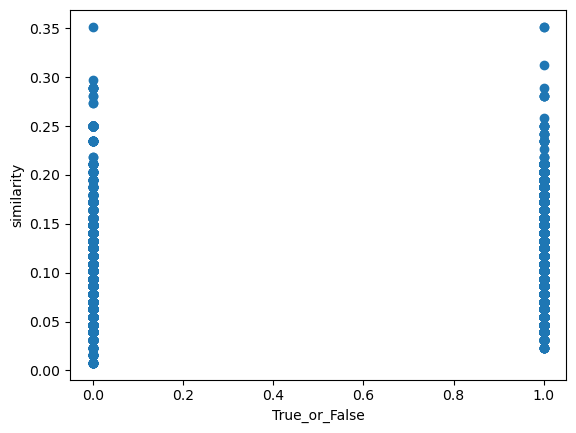

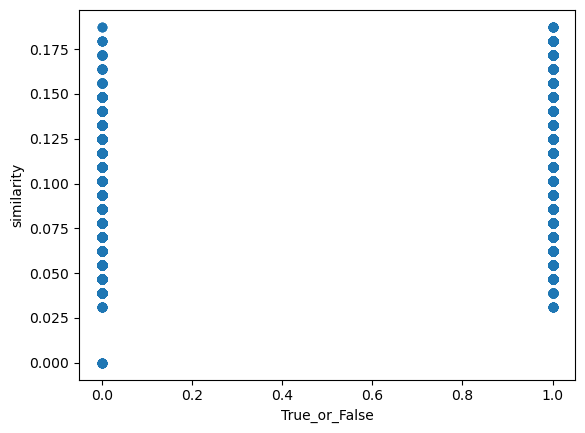

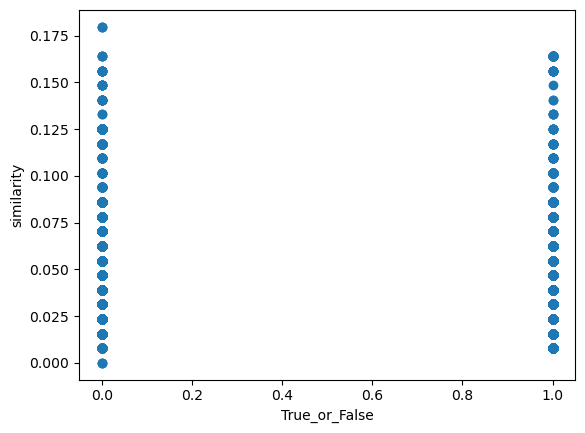

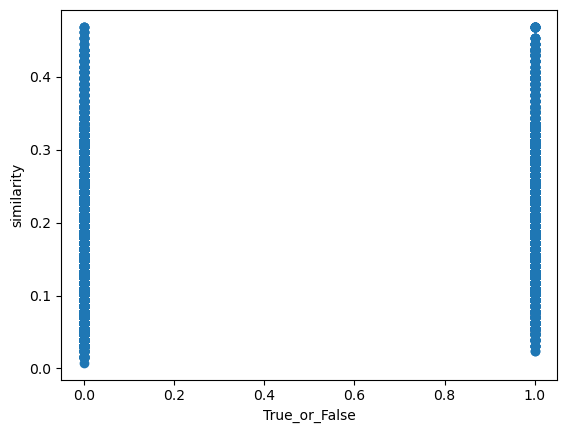

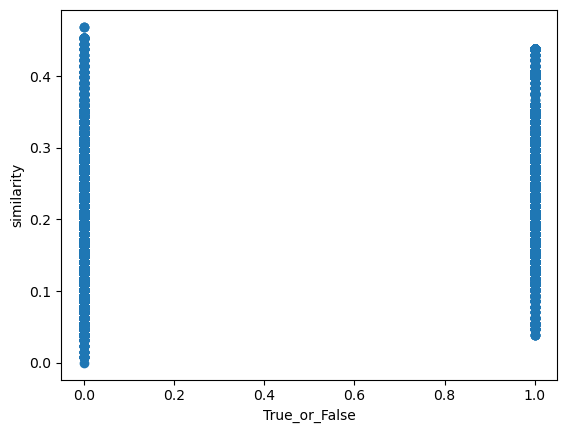

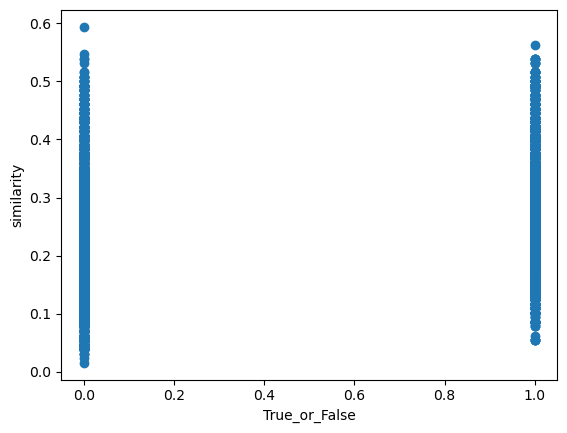

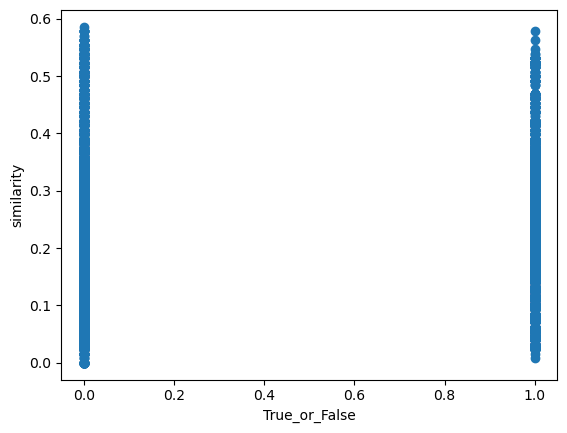

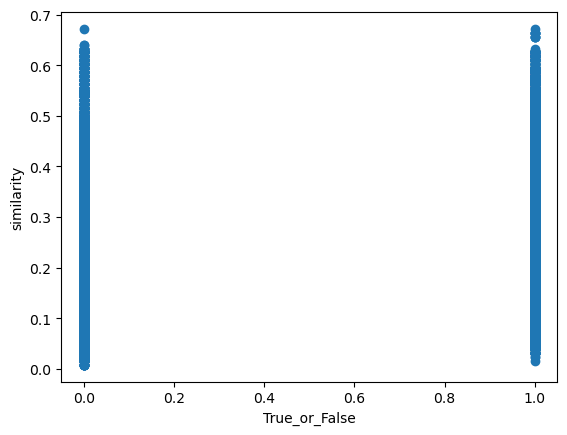

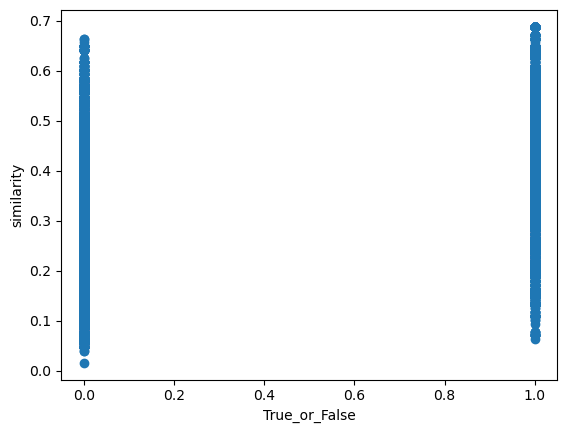

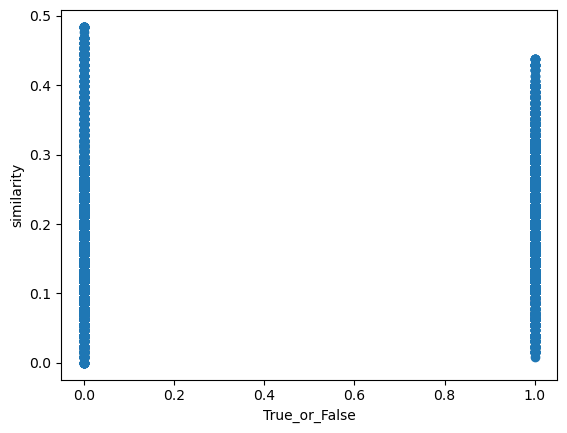

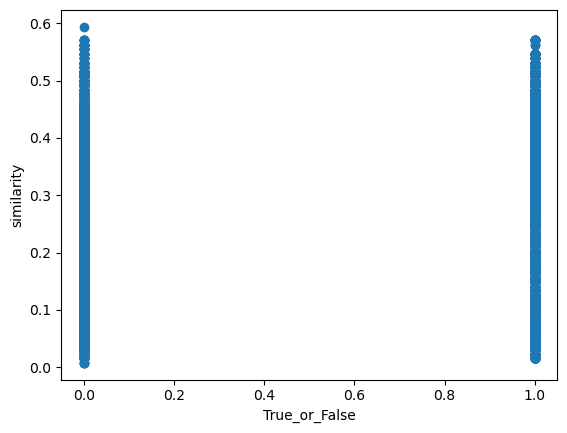

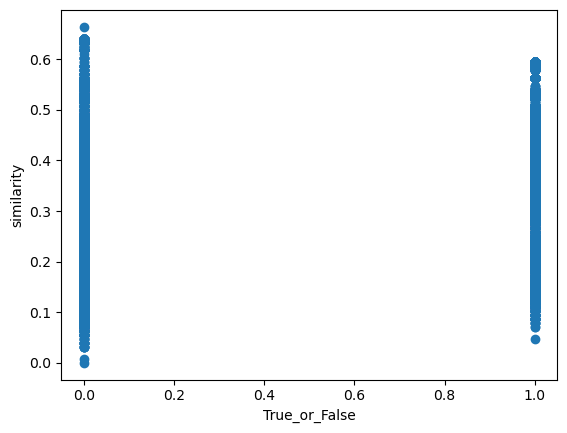

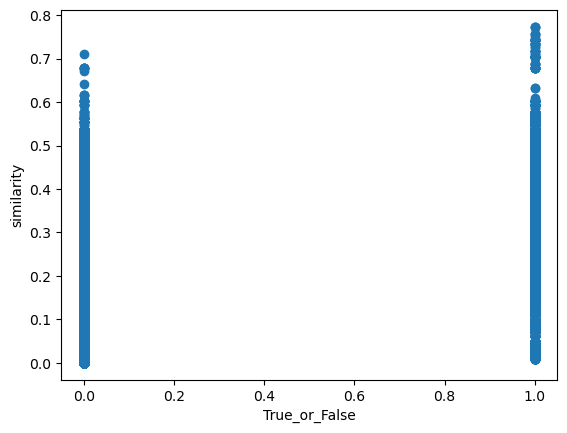

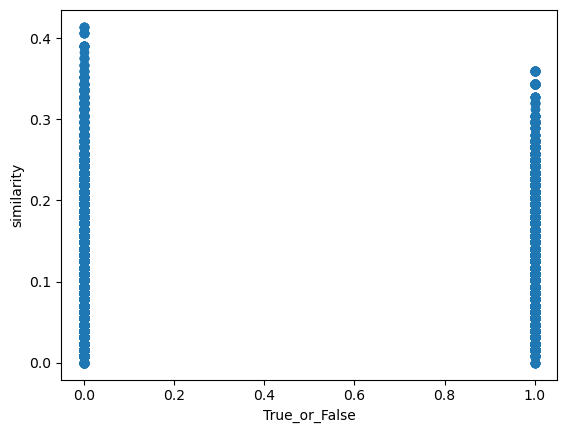

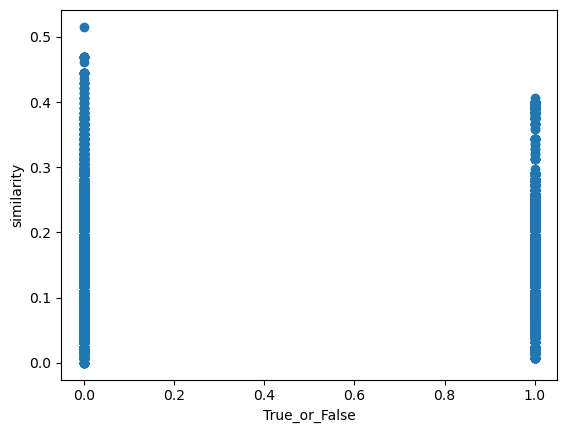

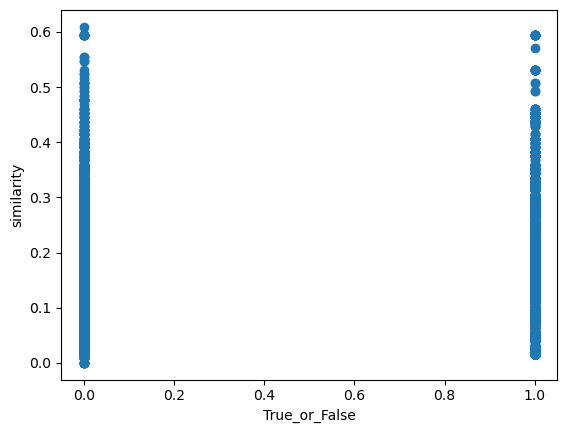

In [ ]:

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import ast
file="./data/code_translation/result/MinHash_CODE"

for root,dirs,files,in os.walk(file):
    for file in files:
        path=os.path.join(root, file) 
        with open(path,'r')as f1:
            mylist=f1.readlines()
            true_list=ast.literal_eval(mylist[0])
            sim_list=ast.literal_eval(mylist[1])
            for i in range(len(true_list)):
                true_list[i]=int(true_list[i])
            plt.scatter(true_list,sim_list)
            plt.xlabel('True_or_False')
            plt.ylabel('similarity')
            plt.show()

In [ ]:
import os
import json
dict_lang={'cpp':'cpp','python':'python','java':'java','js':'javascript','go':'go'}
dict_promptsplit={'cpp': 'C++:', 'go': 'Go:', 'java': 'Java:', 'javascript': 'JavaScript:', 'python': 'Python:'}
def process():
    files="./data/code_translation/code"
    for root,dirs,file in os.walk(files):
        for myfile in file:
            code1list=[]
            code2list=[]
            truelist=[]
            string=myfile.split('-to-')
            lang1=dict_lang[string[0].split('-')[-1]]
            lang2=dict_lang[string[1].split('-')[0]]
            print(lang1,lang2)
            path=os.path.join(root, myfile) 
            with open(path,'r')as f1:
                for line in f1:
                    obj=json.loads(line)
                    string1=obj['prompt']
                    string1=string1.split(dict_promptsplit[lang1])[1]
                    code1=string1.split(dict_promptsplit[lang2])[0]	
                    code2=string1.split(dict_promptsplit[lang2])[1]+obj['generation']
                    code1list.append(code1)
                    code2list.append(code2)	
                    truelist.append(obj['passed'])
            with open(r'./data/code_translation/text/'+lang1+'-to-'+lang2+'.txt','w') as f:
                lastcode1=""
                lastcode2=""
                count=0
                count1=0
                for i in range(len(code1list)):
                    
                    if code1list[i]!=lastcode1:
                        count1+=1
                        count=0
                        f.write(str(count1)+'\n')
                        f.write(lang1)
                        f.write('\n')
                        lastcode1=code1list[i]
                        f.write('\nBefore  Translation\n')
                        f.write(code1list[i])
                        f.write('\n')
                        f.write('\n')
                    
                    if code2list[i]!=lastcode2:
                        if truelist[i]==True:
                            '''count+=1
                            if count<4:
                                f.write(lang2)
                                f.write('\n')
                                lastcode2=code2list[i]
                                f.write('\nAfter  Translation\n')
                                f.write(str(truelist[i]))
                                f.write(code2list[i])
                                f.write('\n')'''
                        else:
                            count+=1
                            if count<4:
                                f.write(lang2)
                                f.write('\n')
                                lastcode2=code2list[i]
                                f.write('\nAfter  Translation\n')
                                f.write(str(truelist[i]))
                                f.write(code2list[i])
                                f.write('\n')
                    if count1>20:
                        break
                f.close()
process()

cpp python
go python
java python
javascript python
cpp java
cpp javascript
go cpp
go java
go javascript
java cpp
java javascript
javascript cpp
javascript java
python cpp
python java
python javascript
cpp python
go python
java python
javascript python
cpp java
cpp javascript
go cpp
go java
go javascript
java cpp
java javascript
javascript cpp
javascript java
python cpp
python java
python javascript
